
# <center> MIP Calibration Procedure for Prototype Sampling Layers</center>


In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import pandas as pd
import uproot as ur
import statistics
import k3d
import numpy as np
import awkward as ak
import matplotlib.colors as mcolors
from scipy.stats import norm
import mplhep as hep
import hist
from hist import Hist
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
from matplotlib.ticker import ScalarFormatter

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["legend.fontsize"] = 16

In [53]:
#Reading in the ptrig data frame
ptrigDF = pd.read_pickle(r'./PTRIG_LG50_HG50_4k_R28.pkl')

#Reading in the cosmic data frame
cosmicDF = pd.read_pickle(r'./COSMIC_LG50_HG50_4k_R2.pkl')

## PTRIG Data 
Creating histograms of the ptrig data \
Fit them to a Gaussian to find the pedestal for each cell (channel)

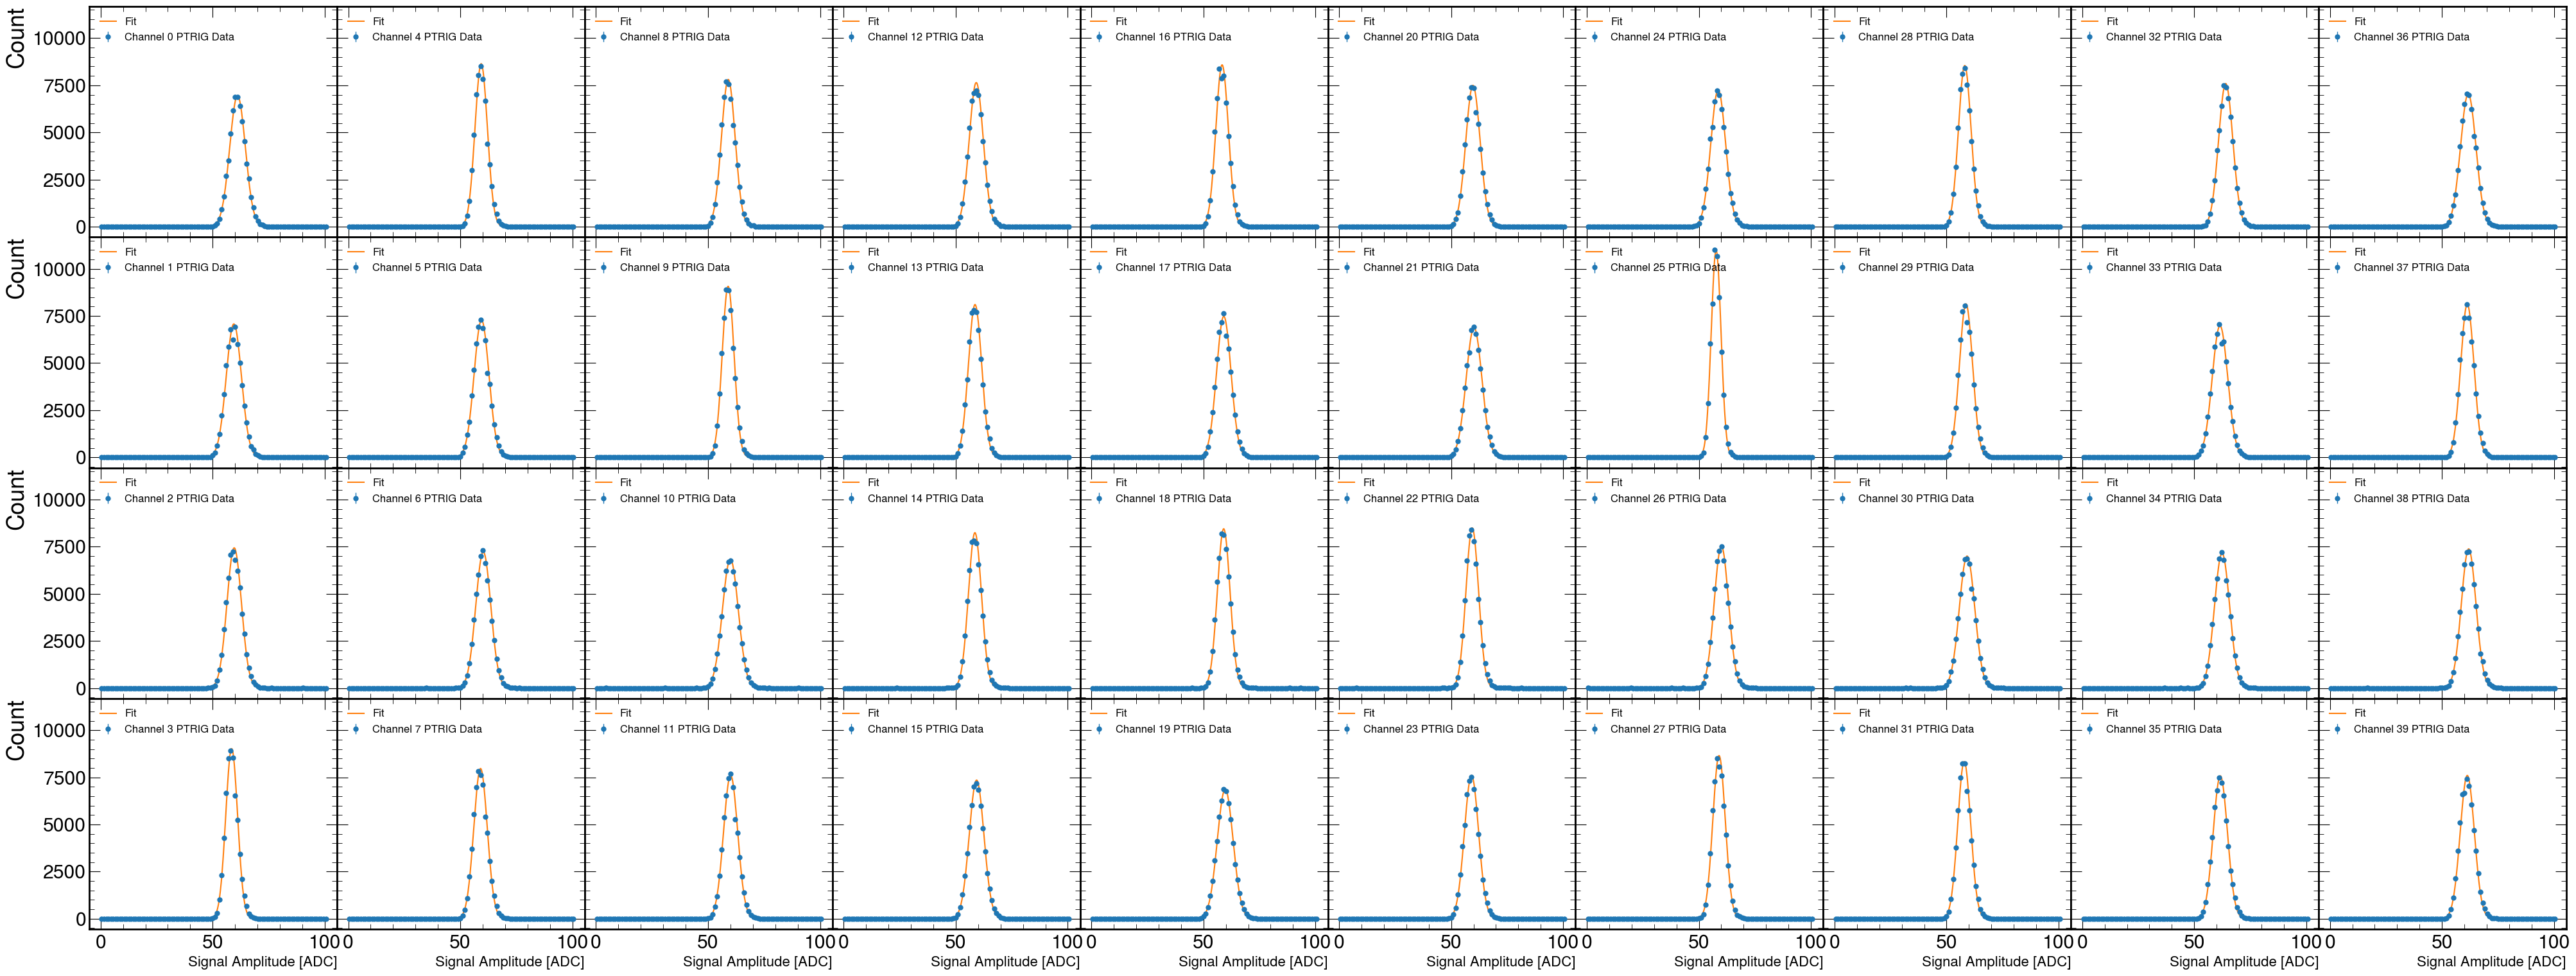

In [54]:
#Plot random trigger spectra for each low gain channel. 
#Fit to gaussian and record pedestals so that we can apply a cut later in the analysis

#Formating the output of the plots
fig, axs=plt.subplots(4, 10, figsize=(0.5*len(ptrigDF.columns),15),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

#Defining the Gaussian function to fit to. 
#A is the amplitude, mu is the pedestal mean value, sigma is the pedestal standard deviation
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

#Defining the arrays of the pedestal means and the standard deviations. Values will be appended in the for loop below
pedMeans = []
pedStds = []

#Looping through each channel i
for i in range(40):
    plt.sca(axs[i%4][i//4])
    
    h = hist.Hist(hist.axis.Regular(100, 0, 101, name="Ptrig"))
    h.fill(np.array(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))))
    #h.plot(color='blue',label=f"Channel {i} PTRIG Data")  
    
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
    bins = bin_centers
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} PTRIG Data")

    # Initial parameter values for the fit
    #initial_params = [max(h), sum(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i))))/len(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))), 2.5]
    initial_params = [10000,60,2.5]
    # Create Minuit object and set up the fit
    x = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    y = h.values()[()]
    yerr = np.sqrt(y)
    mask = y>0
    x = x[mask]
    yerr = yerr[mask]
    y = y[mask]
    m = Minuit(LeastSquares(x, y, yerr, gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    # Set limits for the sigma parameter
    m.limits["sigma"] = (0, None)
    # Perform the fit
    m.migrad()
    # Get the fitted parameters
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']

    
    x = np.linspace(0, 100, 1000)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, 'tab:orange', label='Fit')

    plt.legend(loc='upper left', fontsize=12)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%4 == 0:
        plt.xlabel('Signal Amplitude [ADC]', fontsize=16)
    if i <= 3:
        plt.ylabel('Count')
  
    #plt.yscale("log") 
    
    pedMeans.append(mu_fit)
    pedStds.append(sigma_fit)
    
# Adjust the spacing between subplots
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

Creating a visual of the pedestal mean values and their average value overall. 

Average mean value:
59.75048891126496
Average width value:
3.113644290713009
Standard Deviation of mean values: 1.3591970084831793


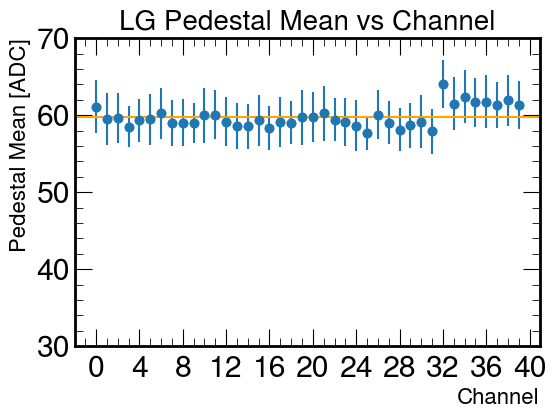

In [81]:
#Plotting pedestal means and stds for Low Gain
fig = plt.figure(figsize=(6, 4))
plt.scatter(range(0,40),pedMeans)
plt.xlabel('Channel', fontsize=16)
plt.ylabel('Pedestal Mean [ADC]', fontsize=16)
plt.title("LG Pedestal Mean vs Channel", fontsize=20)
plt.errorbar(range(0,40), pedMeans, yerr=pedStds, fmt="o")
plt.ylim(30, 70)

#Geting the average value
avg = np.mean(pedMeans)

# Plot a horizontal line for the average
plt.axhline(y=avg, color='orange', label='Average')

x_ticks = np.arange(0, 41, 4)
plt.xticks(x_ticks)

#Printing the Average pedestal mean value
print("Average mean value:")
print(np.mean(pedMeans))
print("Average width value:")
print(np.mean(pedStds))

#Printing the standard deviation of the pedMeans array
pedMeans_list = list(pedMeans)

# Calculate the standard deviation
pedMeans_stdev = statistics.stdev(pedMeans_list)

print("Standard Deviation of mean values:", pedMeans_stdev)
#print(pedMeans)
#print(pedStds)

## Cosmic Data
Subtracting the $(Pedestal Mean) + 4\sigma$ from the cosmic data, hence subtracting out the noise.\
Only selecting events in which cells directly in front and behind the cell in analysis are activated.\
Plotting the remaining data in a histogram and fitting to a landau to find. The mean value of the landau is the MIP value.

C:\Users\peter\AppData\Local\Temp\ipykernel_13124\1879786545.py:11: RuntimeWarning: overflow encountered in exp
  return Aprime*np.exp((-u)/2 - np.exp(-u)/2)


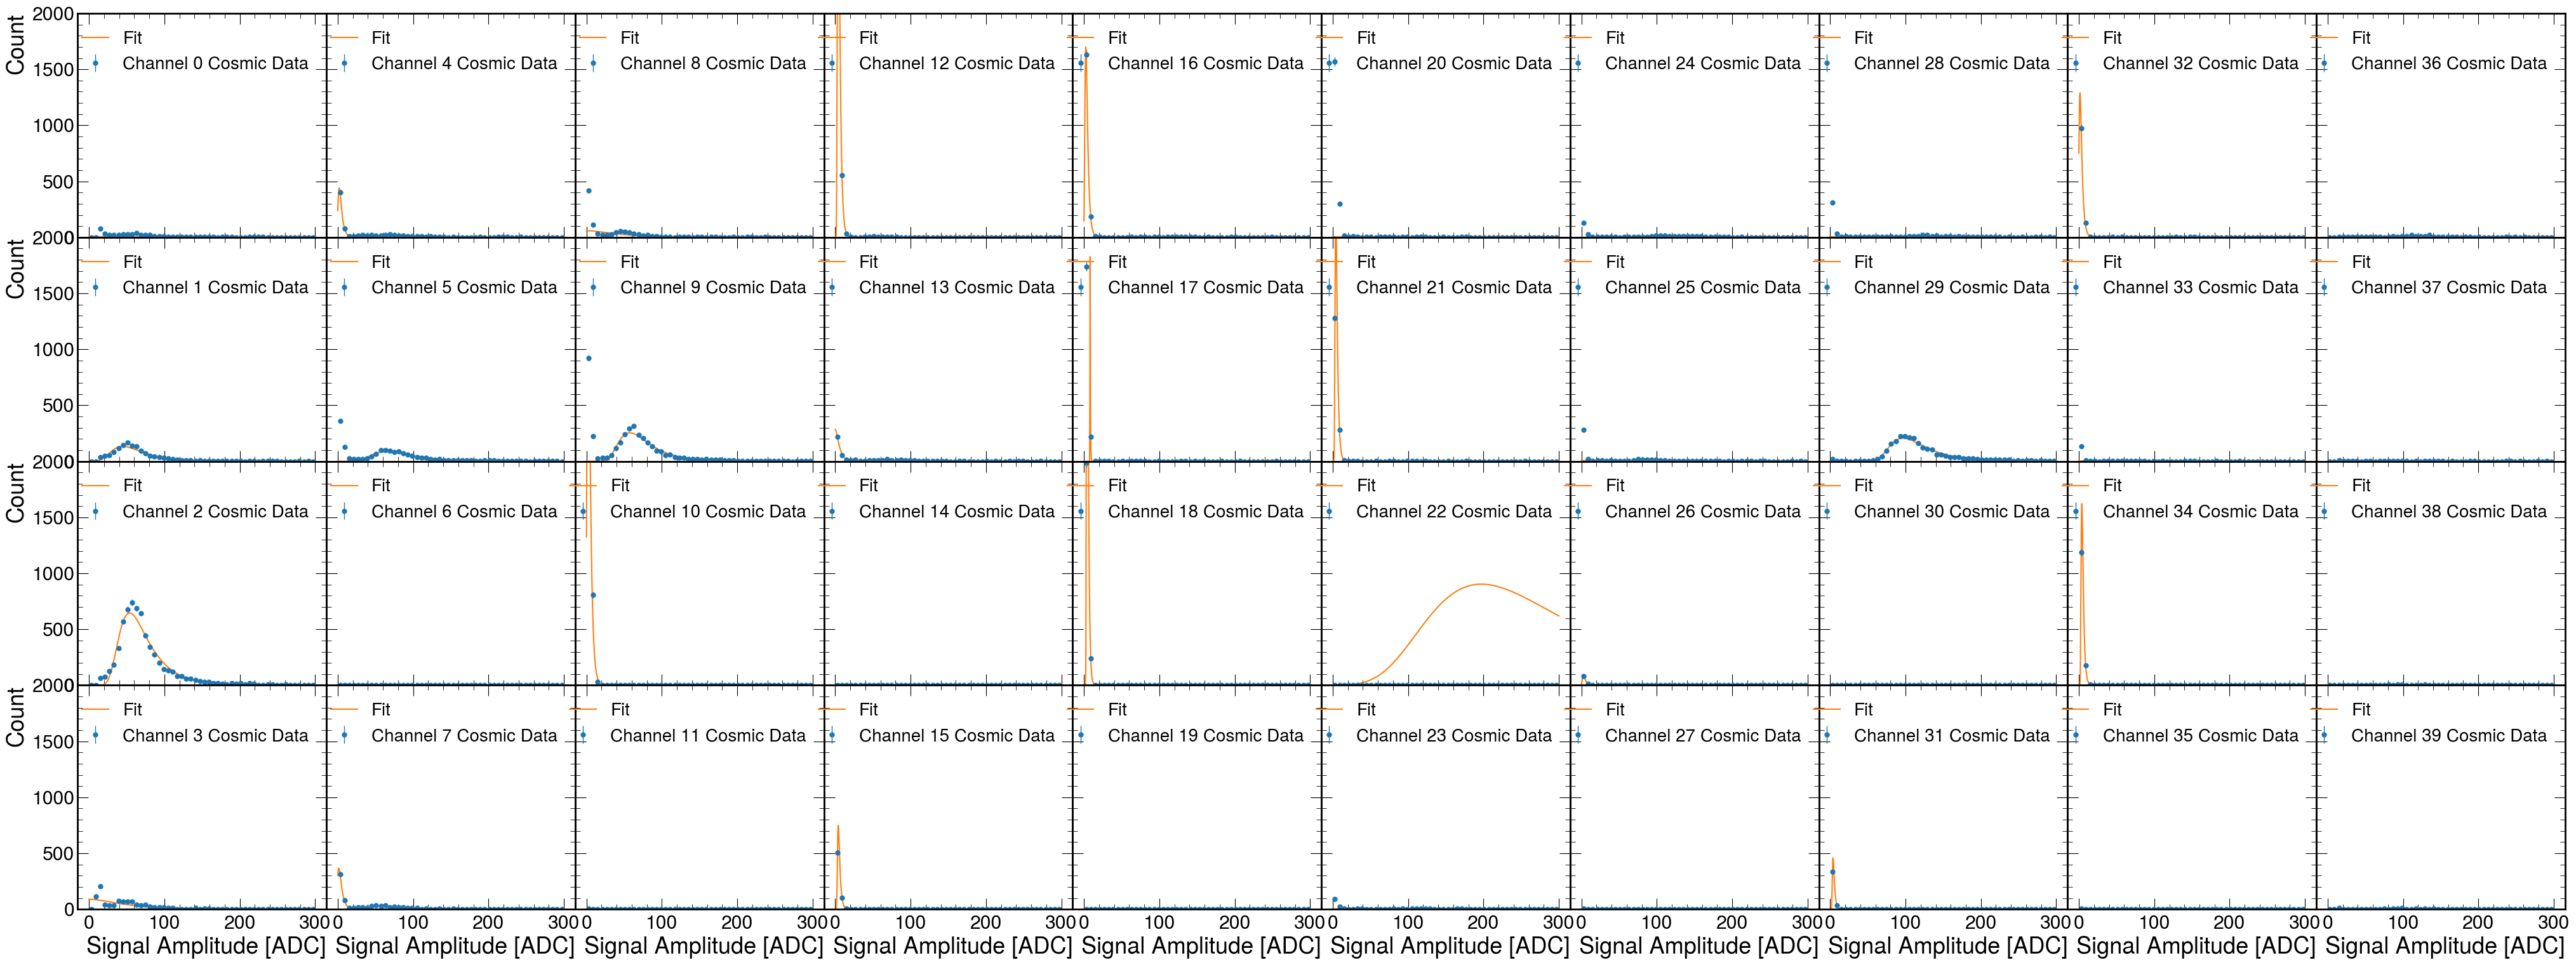

In [84]:
#Creating the format of the plots
fig, axs=plt.subplots(4, 10, figsize=(0.5*len(cosmicDF.columns),15),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

#We are defining our Landau curve function that we will fit to
def landau(x, A, mu, sigma):
    u = (x - mu)*3.591/(sigma/2.355)
    Aprime = 1.648*A
    return Aprime*np.exp((-u)/2 - np.exp(-u)/2)

def least_squares_landau(A, mu, sigma):
    y = landau(bins, A, mu, sigma)
    return np.sum((data - y)**2)

#Defining our MIP and standard deviation arrays
mips = []
mipStds = []

#Looping through all the channels in the Cosmic data frame
for i in range(round(len(cosmicDF.columns)/2)):
    plt.sca(axs[i%4][i//4])

    h = hist.Hist(hist.axis.Regular(50, 0, 300, name="Ptrig"))
    
    cosmicCh = np.array(getattr(cosmicDF,"Ch_{}_LG".format("{:02d}".format(i))))
    
    if i < 4:
        # Check the next cell in sequence (i+4) and the cell behind that one (i+8) for the first sampling layer
        
        #Defining the arrays of adc's from the two cells behind cell i. 
        nextcell = np.array(getattr(cosmicDF, "Ch_{:02d}_LG".format(i + 4)))
        nextnextcell = np.array(getattr(cosmicDF, "Ch_{:02d}_LG".format(i + 8)))
        
        #Defining the masks. We want to only select values in cell i in which cells i+4 and i+8 also had an energy above a certain value
        mask_1 = nextcell >= (pedStds[i+4]*4)+pedMeans[i+4]
        mask_2 = nextnextcell >= (pedStds[i+8]*4)+pedMeans[i+8]
        mask_3 = cosmicCh >= (pedStds[i]*4)+pedMeans[i]
        
        # Combine the masks using logical AND
        mask = np.logical_and(mask_1, mask_3)
        
        #Apply the mask onto the Cosmic data frame and subtract the pedMeans value from the x axis. 
        cosmicCh = cosmicCh[mask] - pedMeans[i]
    
    elif i > 35:
        # Check the previous cell in sequence (i-4) and the cell in front of that one (i-8) for the last sampling layer
        prevcell = np.array(getattr(cosmicDF, "Ch_{:02d}_LG".format(i - 4)))
        prevprevcell = np.array(getattr(cosmicDF, "Ch_{:02d}_LG".format(i - 8)))
        
        #Defining the masks. We want to only select values in cell i in which cells i-4 and i-8 also had an energy above a certain value
        mask_1 = prevcell >= (pedStds[i-4]*4)+pedMeans[i-4]
        mask_2 = prevprevcell >= (pedStds[i-8]*4)+pedMeans[i-8]
        mask_3 = cosmicCh >= (pedStds[i]*4)+pedMeans[i]
        
        mask = np.logical_and(mask_1, mask_3)
        cosmicCh = cosmicCh[mask] - pedMeans[i]
        
    else:
        # For channels in between, checking the cell in front and behind the channel i
        nextcell = np.array(getattr(cosmicDF, "Ch_{:02d}_LG".format(i + 4)))
        prevcell = np.array(getattr(cosmicDF, "Ch_{:02d}_LG".format(i - 4)))
        
        #Defining the masks. We want to only select values in cell i in which cells i+4 and i-4 also had an energy above a certain value
        mask_1 = nextcell >= (pedStds[i+4]*4)+pedMeans[i+4]
        mask_2 = prevcell >= (pedStds[i-4]*4)+pedMeans[i-4]
        mask_3 = cosmicCh >= (pedStds[i]*4)+pedMeans[i]
        
        mask = np.logical_and(mask_1, mask_2, mask_3)
        cosmicCh = cosmicCh[mask] - pedMeans[i]

    #Populating the histogram with the cosmic array
    h.fill(cosmicCh)
  
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
    bins = bin_centers
    
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} Cosmic Data")

    # Find the bin number with the maximum value
    max_bin_number = np.argmax(h.values())

    # Get the axis from the histogram
    axis = h.axes[0]

    # Find the x-coordinate corresponding to the maximum bin
    x_coordinate = axis.edges[max_bin_number]
    #mips.append(x_coordinate)
    
    # Initial parameter values for the fit
    initial_params = [max(h), np.mean(cosmicCh), np.std(cosmicCh)]
    
    # Create Minuit object and set up the fit
    x = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    y = h.values()[()]
    yerr = np.sqrt(y)
    mask = y>0
    x = x[mask]
    yerr = yerr[mask]
    y = y[mask]
    cost = LeastSquares(x, y, yerr, landau)
    m = Minuit(cost, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    # Set limits for the sigma parameter
    m.limits["sigma"] = (0, None)
    m.limits["mu"] = (0, 200)
    # Perform the fit
    m.migrad()
    # Get the fitted parameters
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    
    #Creating the plot of the curve fit
    x = np.linspace(0, 300, 1000)
    y_fit = landau(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, 'tab:orange', label='Fit')

    plt.legend(loc='upper right', fontsize=20)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%4 == 0:
        plt.xlabel('Signal Amplitude [ADC]')
    if i <= 3:
        plt.ylabel('Count')
    
    mips.append(mu_fit)
    mipStds.append(sigma_fit)
    
# Adjust the spacing between subplots
plt.ylim(0,2000)
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

Creating a visual of the MIP values for each cell

Average mean value:
59.322844243377745
Average width value:
4113.175377725532


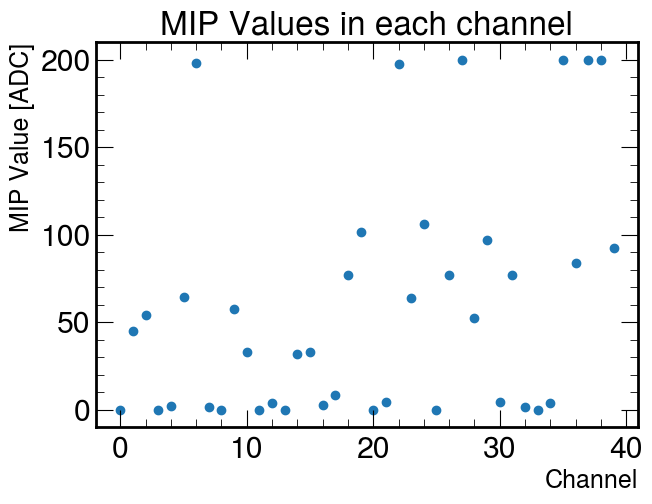

In [89]:
mips = np.array(mips)

fig = plt.figure( figsize=(7, 5))
plt.scatter(range(0,40),mips)
plt.xlabel('Channel', fontsize=18)
plt.ylabel('MIP Value [ADC]', fontsize=18)
plt.title('MIP Values in each channel', fontsize = 24)

print("Average mean value:")
print(np.mean(mips))
print("Average width value:")
print(np.mean(mipStds))